# Toy Project Analyzing my Spotify Playlist
Data crawled with https://dev.peterfiorella.com/spotifyexport/public/#

In [112]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
import networkx as nx
import community

In [113]:
# Read the JSON file
with open('data/spotify-playlists-2023-07-18.json') as f:
    data = json.load(f)

# Extract the "tracks" field from the first object in the array
tracks = data[0]['tracks']

# Normalize the "tracks" field into a DataFrame
df = pd.json_normalize(tracks)

print(df.head())

                                 name                    artist  \
0  Shine - Gabriel Drew & Bloom Remix                  Spektrem   
1                         Why We Lose  [Cartoon, Coleman Trapp]   
2                               Alone              Main Reaktor   
3                        Collins Ave.                    Umpire   
4                             Cloud 9              [Tobu, Itro]   

                                album                                   uri  
0  Shine (Gabriel Drew & Bloom Remix)  spotify:track:157s6uDH7vmaomqnGd2uab  
1                         Why We Lose  spotify:track:5NmENli4oodYuWrI0vSGK4  
2                               Alone  spotify:track:7kDwexX6zo1rA5ekQcIhG0  
3                        Collins Ave.  spotify:track:0pNo7OBAmqnSUL18dYAAPx  
4                             Cloud 9  spotify:track:7pPoBydlANHqWDYgm2DkSK  


In [114]:
# Helper functions

def getCountsFromDict(df, key):
  ret = {}

  for i in df[key]:
    if type(i) == list:
      for j in i:
        if j in ret:
          ret[j] += 1
        else:
          ret[j] = 1
    else:
      if i in ret:
        ret[i] += 1
      else:
        ret[i] = 1

  # Sort the dictionary by value
  ret = dict(sorted(ret.items(), key=lambda item: item[1], reverse=True))
  return ret

def getAlbumCountsFromDict(df):
  ret = {}
  key = 'album'

  for i in df[key]:
    # Get the artist name from original df
    artist = df[df[key] == i]['artist']

    artist = artist.iloc[0]
    if type(artist) == list:
      artist = artist[0]

    if i + " #-# " +  artist in ret:
      ret[i + " #-# " + artist] += 1
    else:
      ret[i + " #-# " + artist] = 1

  # Sort the dictionary by value
  ret = dict(sorted(ret.items(), key=lambda item: item[1], reverse=True))
  return ret

## Album statistics

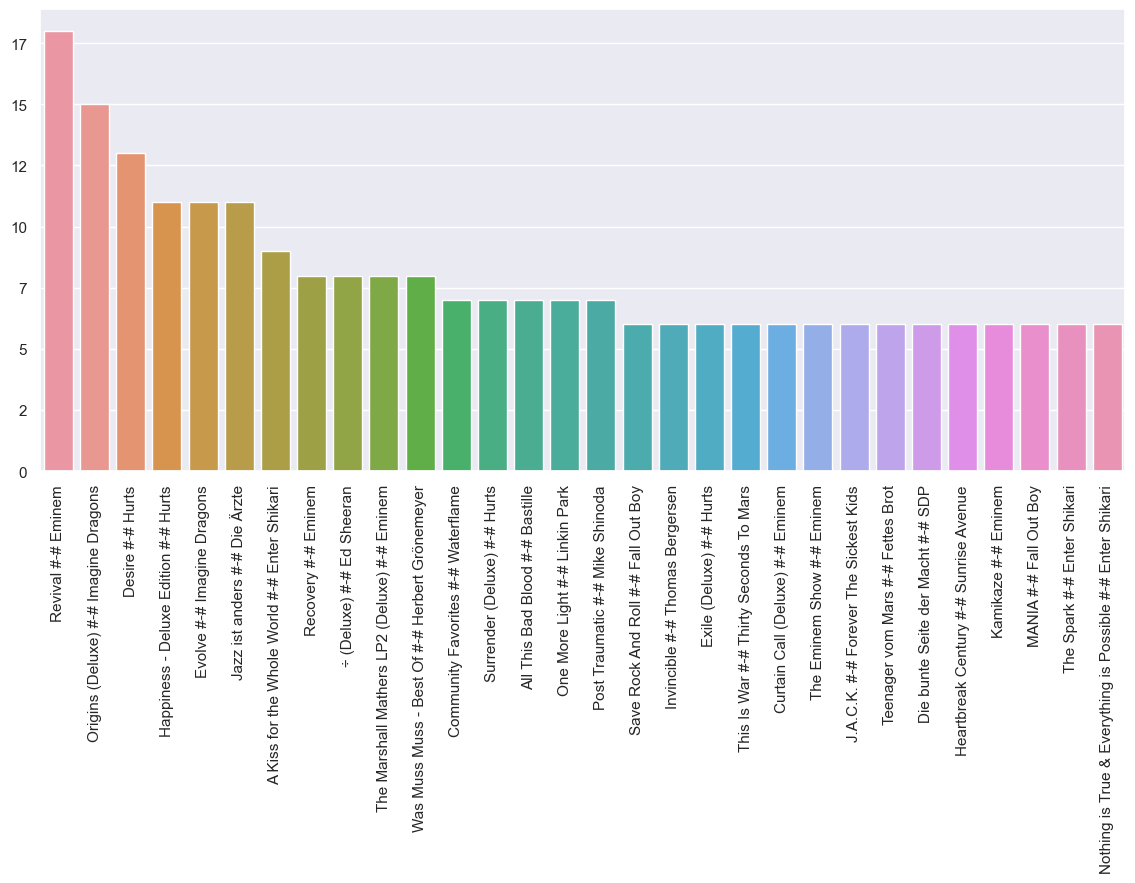

In [115]:
album = getAlbumCountsFromDict(df)

# Print the top 30 albums in a bar chart with seaborn

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(14,6)})
plot = sns.barplot(x=list(album.keys())[:30], y=list(album.values())[:30])
plot.yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.xticks(rotation=90)
plt.show()

## Artist statistics

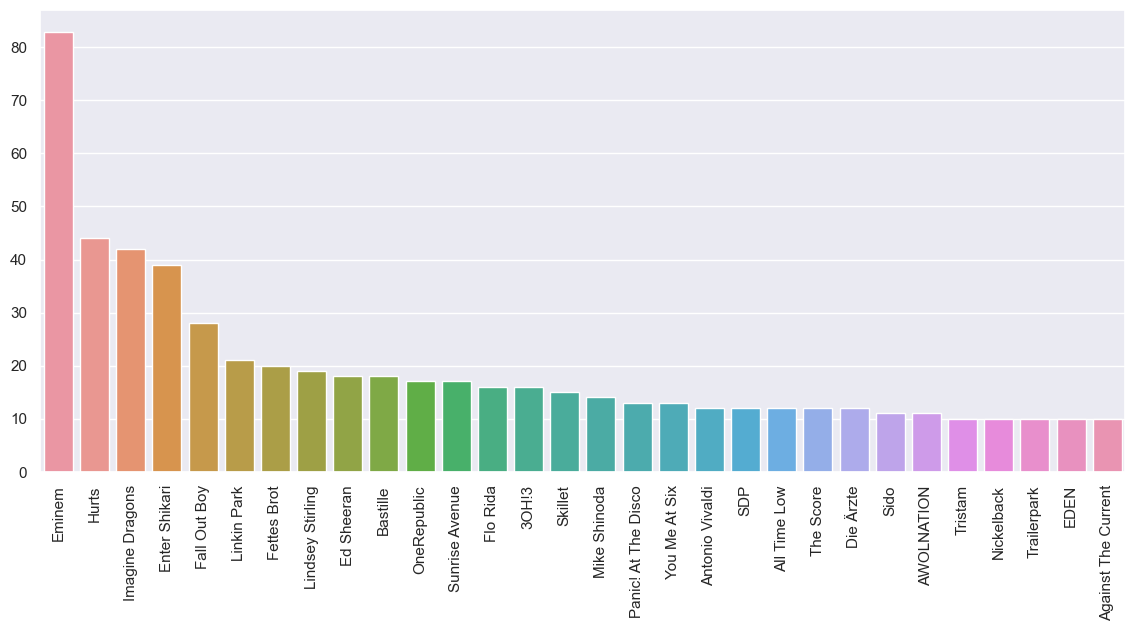

In [116]:
artist = getCountsFromDict(df, 'artist')

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(14,6)})
plot = sns.barplot(x=list(artist.keys())[:30], y=list(artist.values())[:30])
plot.yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.xticks(rotation=90)
plt.show()

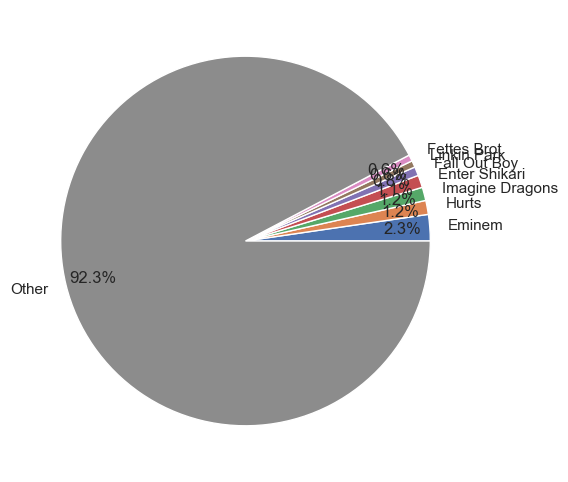

In [117]:
# Create Pie Chart of all artists binning all artists with less than gamma % of total songs into "Other"
artist = getCountsFromDict(df, 'artist')

# Get the total number of songs
total = df.shape[0]
gamma = 0.7

# Get the total number of songs by artists with more than gamma % of total songs
totalTop = 0
for i in artist:
  if artist[i]/total > gamma / 100:
    totalTop += artist[i]

# Create a new dictionary with all artists with less than gamma % of total songs binned into "Other"
artistPie = {}
for i in artist:
  if artist[i]/total > gamma / 100:
    artistPie[i] = artist[i]
  else:
    if "Other" in artistPie:
      artistPie["Other"] += artist[i]
    else:
      artistPie["Other"] = artist[i]

# Create the pie chart
plt.pie(artistPie.values(), labels=artistPie.keys(), autopct='%1.1f%%', pctdistance=0.85, labeldistance=1.1)
plt.show()

In [118]:
# Filtering Tracks with Multiple Artists
filtered_df = df[df['artist'].apply(lambda x: isinstance(x, list))]
print(filtered_df.shape[0])

# Building FP-Growth Tree
te = TransactionEncoder()
te_ary = te.fit(filtered_df['artist']).transform(filtered_df['artist'])
fp_df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = fpgrowth(fp_df, min_support=0.001, use_colnames=True)

# Generating Association Rules with Confidence
association_results = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Sorting and Printing Frequent Itemsets with Confidence
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)
print(frequent_itemsets.head(10))

# Sorting and Printing Association Rules with Confidence
association_results = association_results.sort_values(by='confidence', ascending=False)
print(association_results.head(10))

659
       support                                 itemsets
187   0.048558                                 (Eminem)
58    0.018209                        (Antonio Vivaldi)
63    0.015175                               (Flo Rida)
71    0.013657                       (Lindsey Stirling)
67    0.012140                       (Thomas Bergersen)
41    0.012140                           (Robin Schulz)
66    0.012140                    (Two Steps from Hell)
1217  0.012140  (Two Steps from Hell, Thomas Bergersen)
100   0.010622                           (Fall Out Boy)
94    0.010622                                   (Sido)
                                             antecedents  \
0                                        (Coleman Trapp)   
13555  (Fettes Brot, Eißfeldt, Cram, Der Tobi & Das B...   
13562  (Fettes Brot, Cram, Tabularasa, Der Tobi & Das...   
13561  (Fettes Brot, Cram, Tabularasa, Der Tobi & Das...   
13560  (Fettes Brot, Eißfeldt, Der Tobi & Das Bo, Sup...   
13559  (Fettes Brot,

### Graph Analysis
We try to find relationships of artists based on their songs they published together.

In [119]:
import re

G = nx.Graph()

filtered_df = df[df['artist'].apply(lambda x: isinstance(x, list))]

for index, row in df.iterrows():
  if type(row["artist"]) == list:
    for i in row["artist"]:
      G.add_node(re.escape(i))
      for j in row["artist"]:
        if i != j:
          G.add_edge(re.escape(i), re.escape(j))
  else:
    G.add_node(re.escape(row["artist"]))

print(G)

Graph with 2077 nodes and 1070 edges


In [120]:
unconnected_subgraphs = list(nx.connected_components(G))

filtered_subgraphs = [subgraph for subgraph in unconnected_subgraphs if len(subgraph) >= 2]
# Order the subgraphs by size
filtered_subgraphs = sorted(filtered_subgraphs, key=len, reverse=True)

print(len(filtered_subgraphs))

for subgraph in filtered_subgraphs:
  print(subgraph)

327
{'100\\ gecs', 'Alonestar', 'Brendon\\ Urie', 'Ryan\\ Lewis', 'RM', 'Rudimental', 'Graham\\ Candy', 'ZAYN', 'Verdine\\ White', 'Lea\\ Rue', 'Birdman', 'Hayley\\ Williams', 'Don\\ Diablo', 'Wanz', 'Macklemore\\ \\&\\ Ryan\\ Lewis', 'Usher', 'Robin\\ Schulz', 'FRENSHIP', 'All\\ Time\\ Low', 'Panic!\\ At\\ The\\ Disco', 'Madcon', 'Lucas\\ Silow', 'KIDDO', '3OH!3', 'Nate\\ Dogg', 'Bryn\\ Christopher', 'Kesha', 'Foxes', 'Khalid', 'Sam\\ Martin', 'Fall\\ Out\\ Boy', 'Demi\\ Lovato', 'renforshort', 'Ali\\ Gatie', 'Kelly\\ Rowland', 'Lookas', 'Mike\\ Shinoda', 'Elton\\ John', 'Sam\\ Feldt', 'Lindsey\\ Stirling', 'Stormzy', 'Kool\\ Moe\\ Dee', 'Dan\\ Caplen', 'Lush\\ \\&\\ Simon', 'Anne\\-Marie', 'Pink', "Rag'n'Bone\\ Man", 'Nate\\ Ruess', 'Thirty\\ Seconds\\ To\\ Mars', 'John\\ Newman', 'Syn\\ Cole', 'Charlie\\ Puth', 'Kiesza', 'Flo\\ Rida', 'Dia\\ Frampton', 'Skylar\\ Grey', 'Matt\\ Squire', 'Taylor\\ Swift', 'Olugbenga', 'K\\.Flay', 'Bakermat', 'X\\ Ambassadors', 'The\\ Seige', 'Redfoo',

#### International Artists Graph
The biggest Subgraph of the Artist Graph is mainly containing well known international artists. Like Linkin Park, Eminem, Katy Perry or Fall Out Boy.

In [121]:
biggest_subgraph = max(filtered_subgraphs, key=len)
print("Size of the Subgraph " + str(len(biggest_subgraph)) + " nodes/artists.")

Size of the Subgraph 196 nodes/artists.


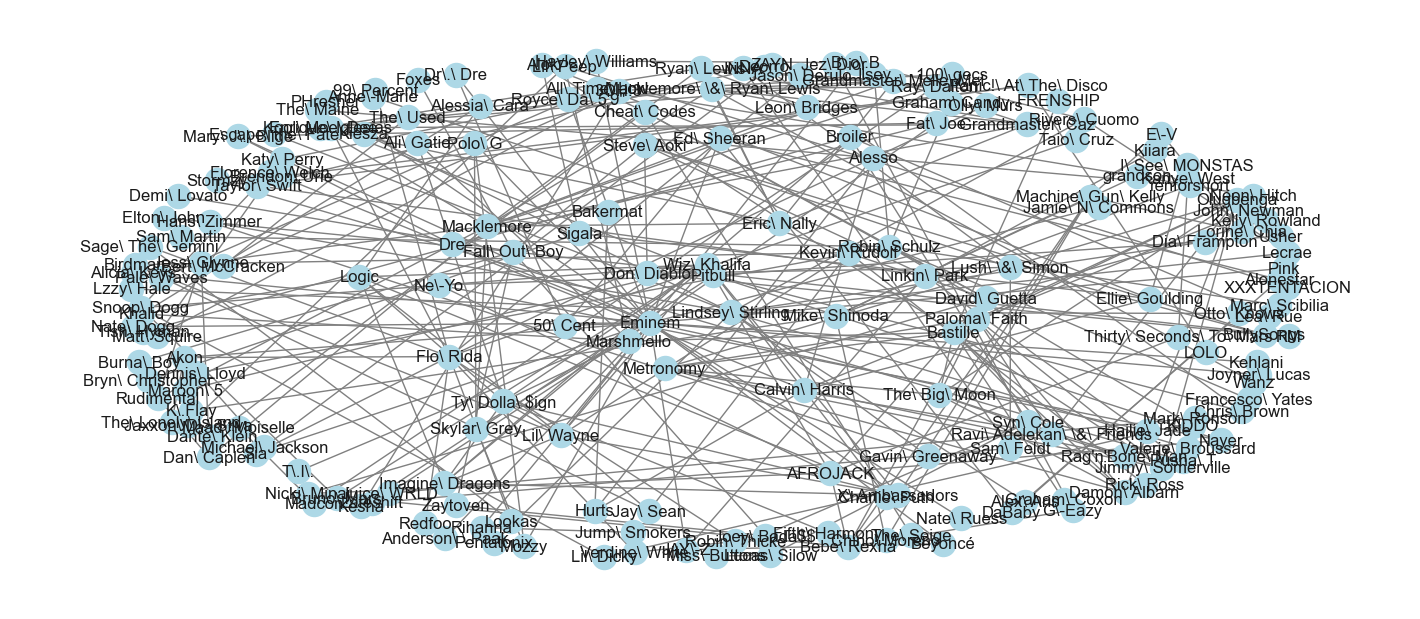

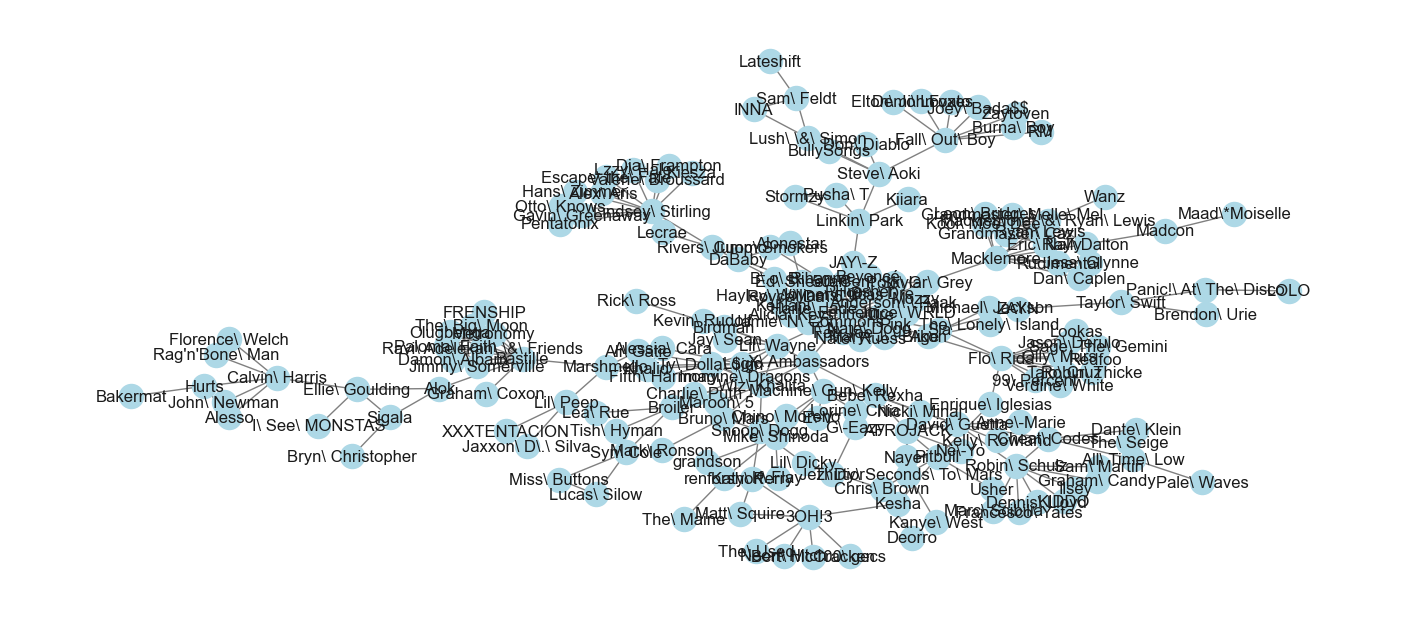

In [122]:
# Create a subgraph of the biggest subgraph
subgraph = G.subgraph(biggest_subgraph)

pos = nx.spring_layout(subgraph, k=1)

# Draw the subgraph using NetworkX and matplotlib with adjusted spacing
nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray')

# Show the graph
plt.show()

pos = nx.kamada_kawai_layout(subgraph)
# Draw the subgraph using NetworkX and matplotlib with adjusted spacing
nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray')

# Show the graph
plt.show()

Prune Graph to only include artists with more than 1 outgoing edges. This removes all artists that only appear once in a feature with another artist as such less interesting to find out about.

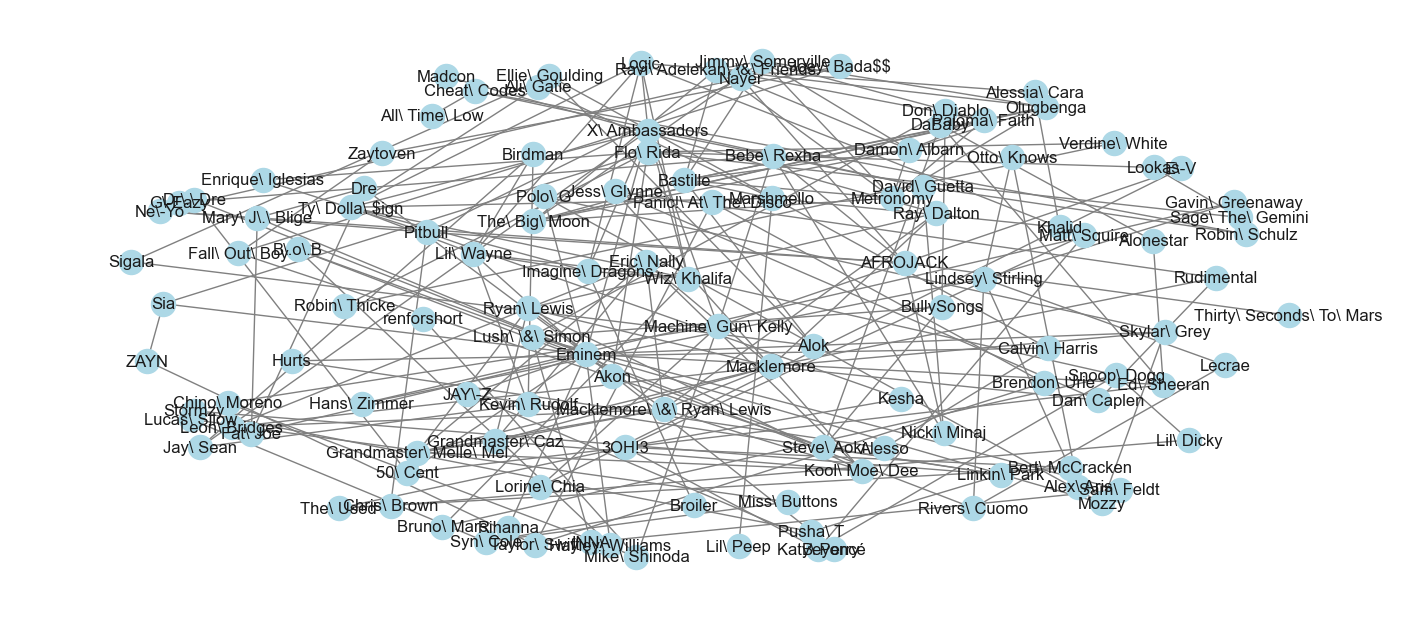

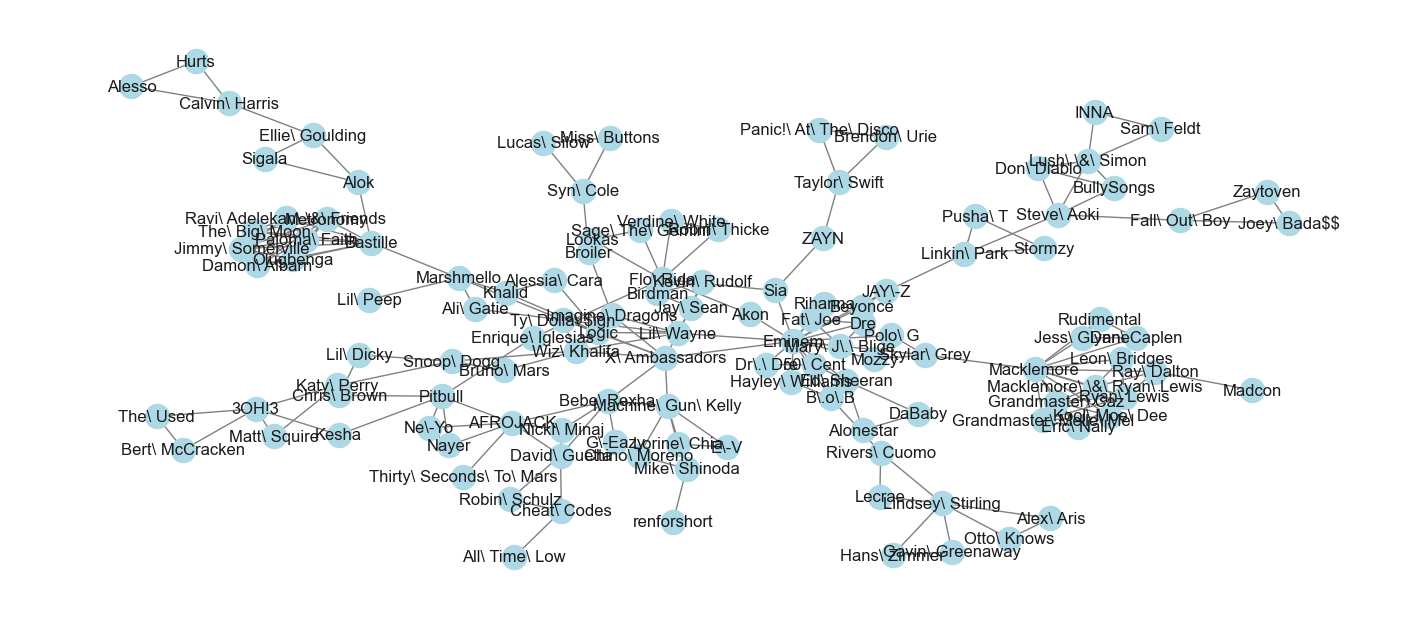

In [123]:
pruned_subgraph = nx.Graph()

for node in subgraph:
  if len(list(G.neighbors(node))) > 1:
    pruned_subgraph.add_node(node)

for edge in subgraph.edges():
  if edge[0] in pruned_subgraph and edge[1] in pruned_subgraph:
    pruned_subgraph.add_edge(edge[0], edge[1])

pos = nx.spring_layout(pruned_subgraph, k=1)

# Draw the subgraph using NetworkX and matplotlib with adjusted spacing
nx.draw(pruned_subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray')

# Show the graph
plt.show()

pos = nx.kamada_kawai_layout(pruned_subgraph)

# Draw the subgraph using NetworkX and matplotlib with adjusted spacing
nx.draw(pruned_subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray')

# Show the graph
plt.show()

### German Artists Colab Graph
The second biggest cluster mainly contains German artists.

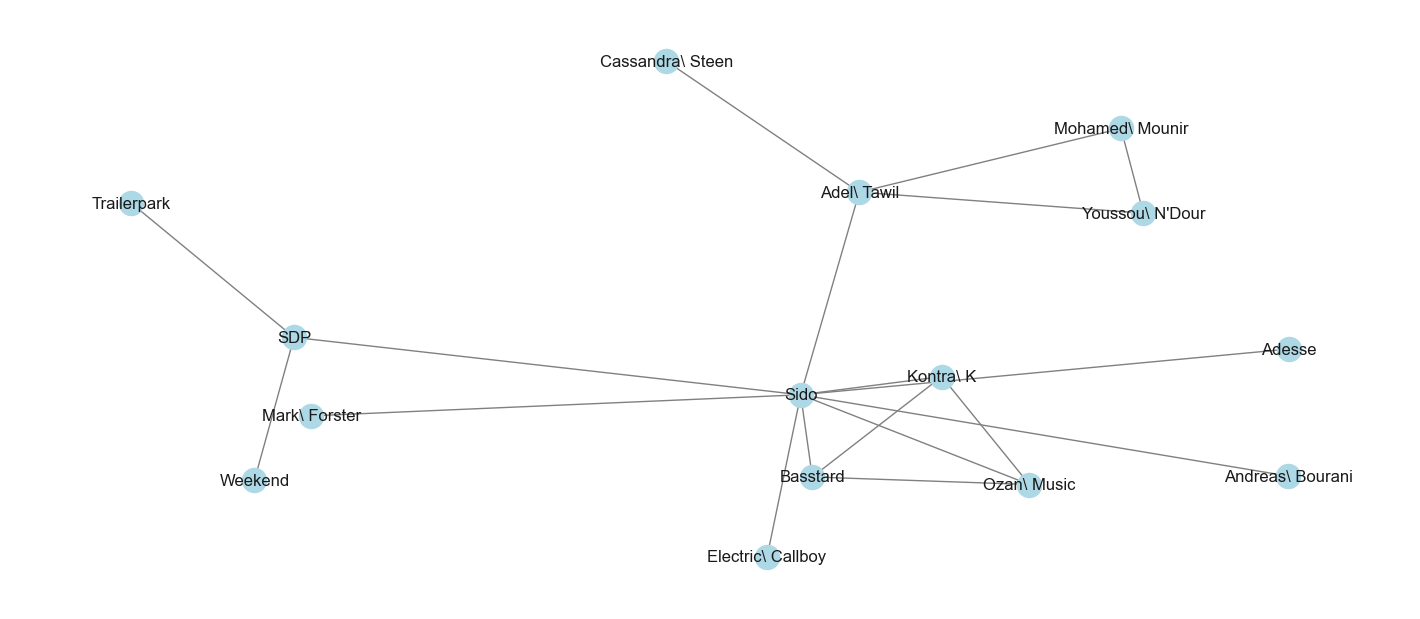

In [124]:
# Get the second biggest subgraph
second_biggest_subgraph = filtered_subgraphs[1]

# Create a subgraph of the second biggest subgraph
subgraph = G.subgraph(second_biggest_subgraph)

pos = nx.spring_layout(subgraph, k=1)

# Draw the subgraph using NetworkX and matplotlib with adjusted spacing
nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray')

# Show the graph
plt.show()